In [1]:
# conda env graphs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image
import pandas as pd 
import numpy as np
from matplotlib.cm import ScalarMappable
import json
import pickle
from itertools import chain
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import random
import itertools
import math

# Functions

In [2]:
def normalize_coordinates(x, y, width, height):
    return x / width, y / height

def calc_norm_distances(centroids_x,centroids_y,image_width,image_height):
    """
    Calculate the normalized distances between each pair of objects in the scene.
    The normalized distances are calculated as the Euclidean distance between each pair of objects,
    normalized by the height and width of the scene.
    """
    # Number of objects
    n = len(centroids_x)
    normalized_centroids = [normalize_coordinates(x, y, image_width, image_height) 
                            for x, y in zip(centroids_x, centroids_y)]
    
    # Initialize a distance matrix
    distances = np.zeros((n, n))

    if np.unique(centroids_x).shape[0] == 1 and np.unique(centroids_y).shape[0] == 1:
        return distances, np.clip(np.zeros_like(distances), 0, 1)

    # Calculate the Euclidean distance between each pair of objects
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.sqrt(
                (normalized_centroids[i][0] - normalized_centroids[j][0])**2 + 
                (normalized_centroids[i][1] - normalized_centroids[j][1])**2
            )
            distances[i, j] = dist
            distances[j, i] = dist  # Fill the symmetric elements
    
    return distances

def calc_angles(centroids_x,centroids_y,image_width,image_height):
    n = len(centroids_x)
    normalized_centroids = [normalize_coordinates(x, y, image_width, image_height) 
                            for x, y in zip(centroids_x, centroids_y)]
    angles = np.zeros((n, n))
    if np.unique(centroids_x).shape[0] == 1 and np.unique(centroids_y).shape[0] == 1:
        return angles, np.clip(np.zeros_like(angles), 0, 1)
    
    for i in range(n):
        for j in range(i + 1, n):
            angle = math.atan2(
                normalized_centroids[j][1] - normalized_centroids[i][1],
                normalized_centroids[j][0] - normalized_centroids[i][0]
            )
            angles[i, j] = angle
            angles[j, i] = angle
    return angles

def prep_scegram_data(consistency, segmentation_report):
    # unique rows
    data_consistency = segmentation_report.loc[(segmentation_report['consistency_scegram'] == "ABS") | (segmentation_report['consistency_scegram'] == consistency)]
    data_grouped = data_consistency.groupby('scene_id')
    return data_grouped

def get_word_embedding(word, model):
    try:
        # Return the word embedding as a NumPy array
        return np.array(model[word])
    except KeyError:
        # If word is not found, return a zero vector as a NumPy array
        return np.zeros(model.vector_size)

In [3]:
# object features: uniform, object, anchor score, diagnosticity score
# edges: uniform, phrase co-occurence, distance in pixel space between centroids, angle between centroids

# 1) Load all object data and create label encoder

In [4]:
trainset = True

data_co_occurrence = pd.read_csv('../results/scene_grammar_reports/obj_pairs_data.csv')
unique_objects_co = np.hstack([data_co_occurrence.obj_a.unique(), data_co_occurrence.obj_b.unique()])
unique_objects_co = np.unique(unique_objects_co)

data_scegram = pd.read_csv(f'../results/scene_grammar_reports/SCEGRAM/segmentation_report_with_scores.csv')
unique_objects_sce = np.unique(data_scegram['object_name'])

data_adek = pd.read_csv(f'../results/scene_grammar_reports/ADEK20K/segmentation_report_with_scores-trainset_{trainset}.csv')
unique_objects_adek = np.unique(data_adek['object_name'])

unique_objects_train = np.unique(np.hstack([unique_objects_co, unique_objects_sce]))#, unique_objects_adek]))

# set difference adek and train
diff_objects_adek = np.setdiff1d(unique_objects_adek, unique_objects_train)
print((diff_objects_adek[:50]))
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit LabelEncoder on all unique categories
label_encoder.fit(list(unique_objects_train))

['C P U ' 'CPU' 'CRT screen' 'Canis familiaris' 'T-shirt' 'VCR' 'abinet'
 'aerial' 'air conditioning' 'air freshener' 'alarm' 'alarm system'
 'anchor' 'andiron' 'animal' 'animate being' 'antler' 'aperture' 'apparel'
 'apron' 'aquarium' 'arcade machine' 'arch' 'archway' 'arm' 'arm panel'
 'arm support' 'armrest' 'asdf' 'ash bin' 'ash-bin' 'ashbin' 'ashcan'
 'asphyxiator' 'automatic washer' 'avocados' 'ax' 'baby chair' 'back'
 'back cushion' 'back pack' 'back pillow' 'backplaete' 'backplate' 'ball'
 'balusters' 'balustrade' 'bananas' 'banister' 'bannister']


LabelEncoder()

In [5]:
print(len(unique_objects_train))

754


In [6]:
# List unique objects
print(unique_objects_train)
print(len(diff_objects_adek))

['adding machine' 'advert' 'air conditioner' 'airplane' 'alarm clock'
 'alarm_clock' 'amplifier' 'antenna' 'apple' 'appliance' 'arcade'
 'armchair' 'art' 'artichokes' 'ashtray' 'attic' 'awning' 'backpack' 'bag'
 'balcony' 'banana' 'bandstand' 'barbacue' 'basket' 'baskets' 'baskets_'
 'bath' 'bath mat' 'bath plug' 'bathrobe' 'bathtub' 'beach' 'bed'
 'bed posts' 'bedding' 'bedskirt' 'bedspread' 'bell' 'bell pepper' 'bench'
 'bicycle' 'bidet' 'bin' 'binder' 'bird' 'birdcage' 'blanket' 'blender'
 'block' 'board' 'board games' 'boat' 'book' 'books' 'bookshelf' 'boot'
 'bottle' 'bottles' 'bouquet' 'bowl' 'box' 'boxes' 'braided garlic'
 'branch' 'bread' 'bridge' 'briefcase' 'broom' 'brush' 'bucket' 'buffalo'
 'buffet' 'buggy' 'building' 'bulletin board' 'buoy' 'bus' 'bus stop'
 'bush' 'business cards' 'butter' 'cabin' 'cabinet' 'cabinets' 'cactus'
 'cake' 'cake dish' 'cake stand' 'cake_liner' 'cake_pan' 'calendar' 'can'
 'canal water' 'candelabra' 'candle' 'candle holder' 'candles' 'canister'

# 2) Load segmentation report

In [118]:
DATASET = 'SCEGRAM' # chose from 'SCEGRAM', 'ADEK20K'
CONSISTENCY = 'CON' # chose from 'CON', 'SEM', 'SYN', 'EXSYN', 'EXSEMSYN', only important for SCEGRAM

if DATASET == 'SCEGRAM':
    trainset_string=''
else:
    trainset_string=f'-trainset_{trainset}'

data = pd.read_csv(f'../results/scene_grammar_reports/{DATASET}/segmentation_report_with_scores{trainset_string}.csv')
data.fillna(0, inplace=True)
# print unique scene id
print(data.scene_id.unique(), len(data.scene_id.unique()))

[ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 57 58 59 60 61 62] 60


count    13274.000000
mean         0.075702
std          0.198788
min          0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.011995
80%          0.073089
90%          0.250000
max          1.000000
Name: co_occ_anchored_prop, dtype: float64


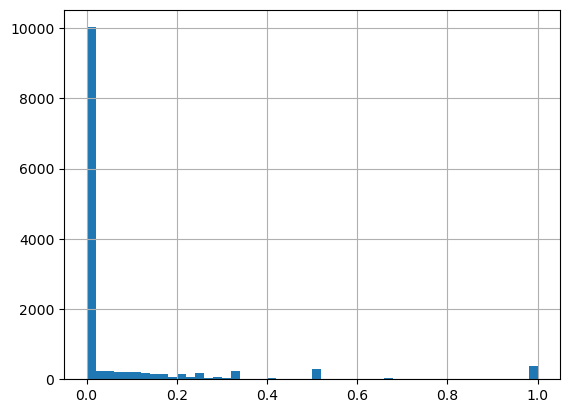

In [119]:
# plot histogram of anchored_prop
data_co_occurrence['co_occ_anchored_prop'].hist(bins=50)
# percentiles
print(data_co_occurrence['co_occ_anchored_prop'].describe(percentiles=[.1, .25, .5, .75,0.8, .9]))

## Generate semantic word embeddings

In [120]:
from gensim.models import KeyedVectors

# Load the pretrained Word2Vec model (Google News in this case)
word2vec_model = KeyedVectors.load_word2vec_format('/Volumes/Extreme SSD/02_computational_scene_grammar/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

# Apply the word embedding extraction to the 'object_name' column
data['word_embedding'] = data['object_name'].apply(lambda x: get_word_embedding(x, word2vec_model))


Group by scene id

In [121]:
# Group by scene_id 
if DATASET == 'ADEK20K':
    data_grouped = data.groupby('scene_id')
elif DATASET == 'SCEGRAM':
    data_grouped = prep_scegram_data(CONSISTENCY, data)

In [75]:
# optional: save to file
#data.to_csv(f'../results/scene_grammar_reports/{DATASET}/segmentation_report_with_scores{trainset_string}-for_loading_images.csv', index=False)

# 3) Create graphs

In [83]:
# File to log images that couldn't be processed
binary_edge = False
anchor_weighted = False
log_file_path = f"../results/graphs/{DATASET}/failed_images_{CONSISTENCY}.txt" if DATASET == 'SCEGRAM' else f"../results/graphs/{DATASET}/failed_images.txt"
failed_images = []
all_distances = []

# dataframe to collect target object ids
if DATASET == 'SCEGRAM':
    data_targets = pd.DataFrame(columns=['scene_id', 'object_id_graph', 'object_name', 'is_target'])

graphs = {}
for image, data_graph in data_grouped:
    scene_id = data_graph['scene_id'].values[0]
    
    #if scene_id == 1000:
    #    break
    
    print('processing scene:', scene_id)
    unique_objects_graph = set(data_graph['object_name'])
    unique_objects_graph = unique_objects_graph.intersection(unique_objects_train)

    # Skip if there's only one object
    if len(unique_objects_graph) <= 1:
        print('skipping scene:', scene_id)
        failed_images.append(data_graph['scene_id'].values[0])
        continue

    G = nx.Graph()
    objects_in_graph = []
    object_id_in_graph = []
    centroids_x = []
    centroids_y = []

    # Add nodes to the graph
    new_id = 0
    for i, row in data_graph.iterrows():
        object_name = row['object_name']
        word_embedding = row['word_embedding']
        object_id = row['object_id']
        if DATASET == 'SCEGRAM':
            if row['consistency_scegram'] != "ABS":
                is_target = True
            else:
                is_target = False
        else:
            is_target = False
        if object_name in unique_objects_train:
            anch = row['anchor_status_freq']
            diag = row['diagnosticity']
            centroids_x.append(row['centroid_x'])
            centroids_y.append(row['centroid_y'])
            objects_in_graph.append(object_name)
            object_id_in_graph.append(new_id)
            G.add_node(new_id, uniform=1, category=label_encoder.transform([object_name])[0], anch=anch, diag=diag, word_embedding=word_embedding)
            # add column to data_graph with new object_id
            data_graph.loc[data_graph['object_id'] == object_id, 'object_id_graph'] = new_id
            
            # add row to data_targets
            new_row = {'scene_id': scene_id, 'object_id_graph': new_id, 'object_name': object_name, 'is_target': is_target}
            # Convert the new row to a DataFrame and concatenate
            if DATASET == 'SCEGRAM':
                data_targets = pd.concat([data_targets, pd.DataFrame([new_row])], ignore_index=True)
            new_id += 1

    if DATASET == 'SCEGRAM':
        image_width = 1024
        image_height = 768
    elif DATASET == 'ADEK20K':
        image_width = data_graph['image_width'].values[0]
        image_height = data_graph['image_height'].values[0]
    
    norm_distances = calc_norm_distances(centroids_x,centroids_y,image_width,image_height) 
    angles = calc_angles(centroids_x,centroids_y,image_width,image_height)
    edges = itertools.combinations(object_id_in_graph, 2)
    # enumerate through edges
    for obj_id_a, obj_id_b in edges:
        #distance = norm_distances[obj_id_a, obj_id_b]
        distance = norm_distances[obj_id_a, obj_id_b]
        all_distances.append(distance)
        angle = angles[obj_id_a, obj_id_b]
        obj_a = data_graph.loc[data_graph['object_id_graph'] == obj_id_a, 'object_name'].values[0]
        obj_b = data_graph.loc[data_graph['object_id_graph'] == obj_id_b, 'object_name'].values[0]
        row = data_co_occurrence[
            (data_co_occurrence['obj_a'] == obj_a) &
            (data_co_occurrence['obj_b'] == obj_b)
        ]
        if not row.empty:
            row = row.iloc[0]
            phraseprop=row['co_occ_phrase_prop']
            anchor_prop=row['co_occ_anchored_prop']
        else:
            phraseprop=0
            anchor_prop=0
        
        if not binary_edge:
            G.add_edge(obj_id_a, obj_id_b, uniform=1, distance=distance, phraseprop=phraseprop, angle=angle, anchor_prop=anchor_prop)
       
        else:
            if anchor_weighted:
                if anchor_prop > 0.8: # for anchor relationships
                    if distance < 0.25: # more strict distance cutoff (0.25 is the 25th percentile)
                        G.add_edge(obj_id_a, obj_id_b, uniform=1, distance=distance, phraseprop=phraseprop, angle=angle, anchor_prop=anchor_prop)
                else:
                    if distance < 0.4: # for low anchor relationship distance cutoff is less strong (0.4 is the 50th percentile)
                        G.add_edge(obj_id_a, obj_id_b, uniform=1, distance=distance, phraseprop=phraseprop, angle=angle, anchor_prop=anchor_prop)
            else:
                if distance < 0.4:
                    G.add_edge(obj_id_a, obj_id_b, uniform=1, distance=distance, phraseprop=phraseprop, angle=angle, anchor_prop=anchor_prop)
    graphs[scene_id] = G
    
# Save the failed images to a log file
if failed_images:
    with open(log_file_path, 'w') as log_file:
        for failed_image in failed_images:
            log_file.write(f"{failed_image}\n")

processing scene: 1
processing scene: 2
processing scene: 3
processing scene: 4
processing scene: 5
processing scene: 6
processing scene: 7
processing scene: 8
processing scene: 9
processing scene: 10
processing scene: 12
processing scene: 13
processing scene: 14
processing scene: 15
processing scene: 16
processing scene: 17
processing scene: 18
processing scene: 19
processing scene: 20
processing scene: 21
processing scene: 22
processing scene: 23
processing scene: 24
processing scene: 25
processing scene: 26
processing scene: 27
processing scene: 28
processing scene: 29
processing scene: 30
processing scene: 31
processing scene: 32
processing scene: 33
processing scene: 34
processing scene: 35
processing scene: 36
processing scene: 37
processing scene: 38
processing scene: 39
processing scene: 40
processing scene: 41
processing scene: 42
processing scene: 43
processing scene: 44
processing scene: 45
processing scene: 46
processing scene: 47
processing scene: 48
processing scene: 49
p

In [53]:
# write data_targets to file
#data_targets.to_csv(f'../results/graphs/{DATASET}/data_targets_{CONSISTENCY}.csv', index=False)

In [54]:
# check sparsity of the graph
sparsity = []
for scene_id, G in graphs.items():
    sparsity.append(nx.density(G))
print(np.mean(sparsity), np.std(sparsity))

# check average degree
average_degree = []
for scene_id, G in graphs.items():
    average_degree.append(np.mean([d for n, d in G.degree()]))
print(np.mean(average_degree), np.std(average_degree))

# plot distribution of distances
plt.hist(all_distances, bins=100)
# quantiles
print(np.quantile(all_distances, [0.1, 0.25, 0.5, 0.75, 0.9]))

0.49102689858052273 0.1145520072759815


In [57]:
# save graphs
nodes = 'uniform_object_anchor_diag_word2vec'
edges = f'uniform_distance_phraseprop_angle_binary_weighted-{anchor_weighted}' if binary_edge else 'uniform_distance_phraseprop_angle'
f_out = f'{DATASET}_{CONSISTENCY}_node{nodes}_edge{edges}_graphs' if DATASET == 'SCEGRAM' else f'{DATASET}_node{nodes}_edge{edges}_graphs'

with open(f"../results/graphs/{DATASET}/{f_out}.json", 'wb') as handle:
    pickle.dump(graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f_out)

## Inspect graphs

In [114]:
CONSISTENCY = 'SYN'
DATASET = 'ADEK20K'
binary_edge = False
anchor_weighted = False
nodes = 'uniform_object_anchor_diag_word2vec'
edges = f'uniform_distance_phraseprop_angle_binary_weighted-{anchor_weighted}' if binary_edge else 'uniform_distance_phraseprop_angle'
f_out = f'{DATASET}_{CONSISTENCY}_node{nodes}_edge{edges}_graphs' if DATASET == 'SCEGRAM' else f'{DATASET}_node{nodes}_edge{edges}_graphs'
#f_out = "SCEGRAM_EXSYN_nodeuniform_object_anchor_diag_edgeuniform_distance_phraseprop_angle_graphs"
#f_out = "SCEGRAM__nodeuniform_object_anchor_diag_word2vec_edgeuniform_distance_phraseprop_angle_binary_weighted-True_graphs"
with open(f"../results/graphs/{DATASET}/{f_out}.json", 'rb') as handle:
    graphs = pickle.load(handle)

In [115]:
len(graphs)

4464

In [116]:
G = graphs[15]
for node, data in G.nodes(data=True):
    print(data, label_encoder.inverse_transform([data['category']])[0])

{'uniform': 1, 'category': 710, 'anch': 0.0, 'diag': 0.1442076612910431, 'word_embedding': array([-6.88476562e-02,  1.59179688e-01,  2.90527344e-02, -9.22851562e-02,
        2.46582031e-02, -2.51953125e-01,  1.47460938e-01, -2.40234375e-01,
        1.92382812e-01,  2.61718750e-01,  7.66601562e-02, -4.14062500e-01,
        8.34960938e-02, -1.87500000e-01, -1.65039062e-01, -1.86523438e-01,
        4.27246094e-02, -2.36511230e-03,  1.20117188e-01, -7.61718750e-02,
        2.48046875e-01,  2.47070312e-01, -7.91015625e-02, -9.81445312e-02,
        9.03320312e-03, -1.86523438e-01,  1.36718750e-01, -1.30615234e-02,
        1.48437500e-01, -3.61328125e-01, -2.01416016e-02, -1.75781250e-01,
        6.07910156e-02, -1.50756836e-02, -8.49609375e-02, -1.98242188e-01,
        1.65039062e-01,  2.91015625e-01,  1.79687500e-01, -1.49414062e-01,
        6.93359375e-02,  3.90625000e-02,  3.49609375e-01, -1.47460938e-01,
        2.41699219e-02,  3.86718750e-01, -2.38281250e-01,  4.76074219e-02,
        2

In [117]:
print(G.edges(data=True))

[(0, 1, {'uniform': 1, 'distance': 0.36054098701336085, 'phraseprop': 0, 'angle': 0.011306625433708556, 'anchor_prop': 0}), (0, 2, {'uniform': 1, 'distance': 0.5673687741297274, 'phraseprop': 0, 'angle': 0.35153163556581946, 'anchor_prop': 0}), (0, 3, {'uniform': 1, 'distance': 0.4792850829235979, 'phraseprop': 0, 'angle': -0.32262966048916686, 'anchor_prop': 0}), (0, 4, {'uniform': 1, 'distance': 0.557657896112033, 'phraseprop': 0, 'angle': 0.911808005367372, 'anchor_prop': 0}), (0, 5, {'uniform': 1, 'distance': 0.557657896112033, 'phraseprop': 0, 'angle': 0.911808005367372, 'anchor_prop': 0}), (0, 6, {'uniform': 1, 'distance': 0.16384804346042234, 'phraseprop': 0, 'angle': 0.6328058540707927, 'anchor_prop': 0}), (0, 7, {'uniform': 1, 'distance': 0.16384804346042234, 'phraseprop': 0, 'angle': 0.6328058540707927, 'anchor_prop': 0}), (0, 8, {'uniform': 1, 'distance': 0.5151568357831151, 'phraseprop': 0, 'angle': 1.3722425681029768, 'anchor_prop': 0}), (0, 9, {'uniform': 1, 'distance': 0

In [58]:
test=pd.read_csv(f'../results/scene_grammar_reports/SCEGRAM/segmentation_report_with_scores.csv')
# unique scene idss
print(test.scene_id.unique(), len(test.scene_id.unique()))
    

[ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 57 58 59 60 61 62] 60


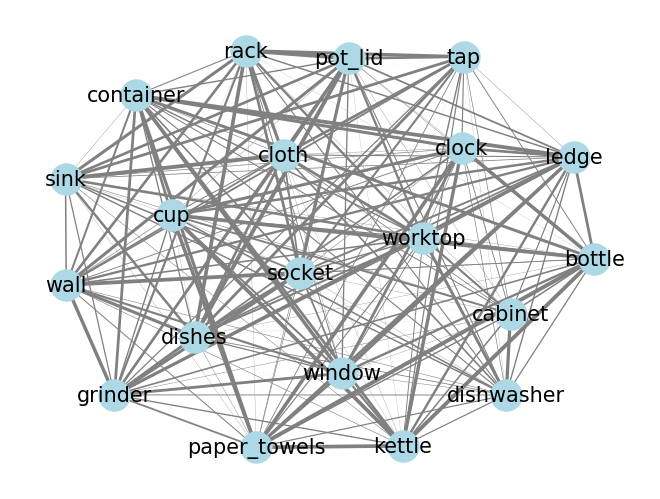

In [88]:
# edge widths based on the 'distance' attribute
edges = G.edges(data=True)
#max_distance = max([data['distance'] for u, v, data in edges])
#min_distance = min([data['distance'] for u, v, data in edges])

# Create a dictionary mapping from label-encoded numbers to original category names
category_mapping = {index: category for index, category in enumerate(label_encoder.classes_)}

# Create node labels using the mapping
node_labels = {node: category_mapping.get(G.nodes[node]['category'], '') for node in G.nodes()}

# node labels uniform feature or category feature
#node_labels = {node: G.nodes[node]['category'] for node in G.nodes()}

edge_widths = [
    (1-data['distance']*4) for u, v, data in edges
]

# Draw the graph with varying edge widths and node feature as label
pos = nx.spring_layout(G)  # You can choose other layouts as well
nx.draw(
    G, pos, with_labels=False, node_color='lightblue', edge_color='grey', 
    node_size=500, font_size=15, width=edge_widths
)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15)

plt.show()
